In [2]:
import torch

# Device configuration
comp = 'cpu'
if torch.cuda.is_available():
    comp = 'cuda' # nvidia gpu parallelization
elif torch.backends.mps.is_available():
    comp = 'mps' # mac Metal Performance Shaders (high performance gpu)

device = torch.device(comp)
device

device(type='mps')

## Download MNIST locally

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True, 
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

print(train_data)
# can potentially add random rotations here as im loading

print(train_data.data.size())

print(train_data.targets.size())

100.0%
100.0%
100.0%
100.0%

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


## Visualization of MNIST dataset

### Plot one train_data

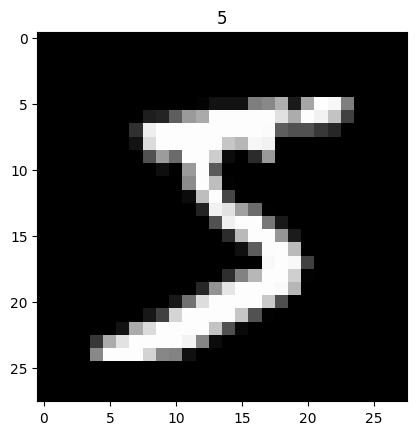

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

### Plot multiple train_data

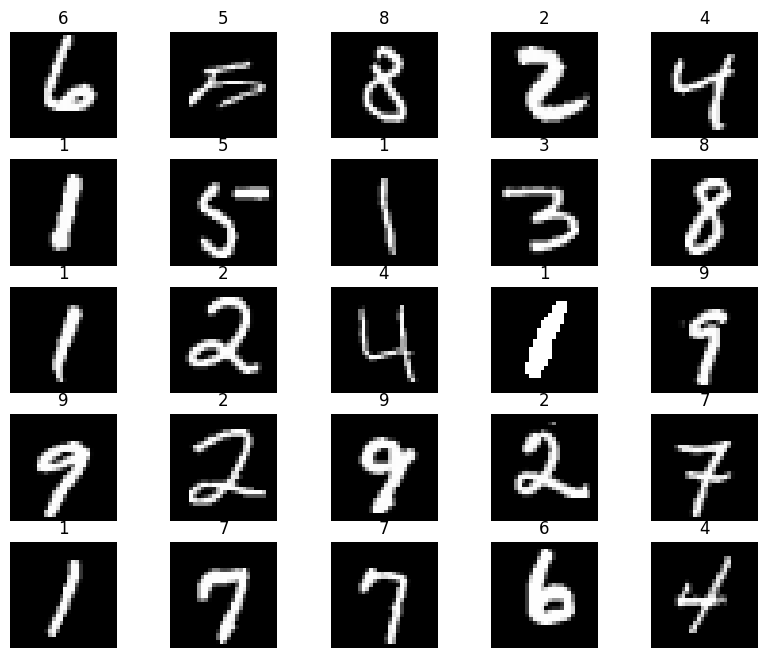

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparing data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [34]:
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data, 
                        batch_size=100, 
                        shuffle=True, 
                        num_workers=4),
    
    'test'  : DataLoader(test_data, 
                        batch_size=32, # reduce this for testing if accessible for end users
                        shuffle=True, 
                        num_workers=4),
}
loaders

# ADD ROTATIONS HERE/TRANSFORMATIONS

{'train': <torch.utils.data.dataloader.DataLoader at 0x14ecb3c20>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x14ecb0710>}

## Define the Convolutional Neural Network model

A Convolutional Neural Network is type of neural network that is used mainly in image processing applications.

Let us create convolution neural network using torch.nn.Module. torch.nn.Module will be base class for all neural network modules. We will use 2 fully convolutional layers, Relu activation function and MaxPooling.

Conv2d: Applies a 2D convolution over an input signal composed of several input planes.

**Parameters**

in_channels (int) — Number of channels in the input image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution. Default: 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1

groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) — If True, adds a learnable bias to the output. Default: True


#### Batch Normalization (BatchNorm)
##### What it does:
Batch normalization normalizes the outputs of a layer by making them have a mean of 0 and variance of 1 within a mini-batch. It then scales and shifts these normalized values using learnable parameters.

##### Why use it:

- Stabilizes training: It keeps the input distributions stable across layers and mini-batches, preventing drastic changes during training.
- Reduces sensitivity to parameter updates: By squishing the distribution, large changes in parameters won’t drastically shift the loss function, allowing smoother and more stable training.
- Faster convergence: Helps the model converge faster by allowing higher learning rates.

#### Notes on Fully Connected Layers and Output in the CNN
##### Padding Effect on Linear Layer Size:
In convolutional networks, padding affects the spatial dimensions of the output. Removing padding results in smaller feature maps, which ultimately reduces the size of the input to the fully connected (linear) layer. This can reduce computational costs but requires adjustments to the dimensions of the fully connected layers.

##### Stacking 2-3 Linear Layers for Non-Linearity:
While the majority of non-linear feature extraction happens in the convolutional layers, stacking multiple linear layers can further improve the model’s capacity to learn complex patterns. However, for simple datasets like MNIST, most of the learning occurs in the convolutional layers, so one or two linear layers are often sufficient.

##### Softmax for Output Probabilities:
The final layer of the CNN outputs 10 nodes, each representing a logit corresponding to a digit class (0-9). To interpret these as probabilities, a softmax function is applied, ensuring that the output values form a probability distribution that sums to 100%. This allows the model to make predictions with interpretable confidence levels.

In [35]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3, # prob drop this to 3 (which is normally done)
                stride=1,                   
                padding=1, # not much of a benefit + computationally efficient w/out, but if it was 0, the dimensions would reduce to 26x26
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),                
        )
        # fully connected layer, output 10 classes
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10) # reduce number of nodes
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output, x    # return x for visualization

in_channels=1: because our input is a grayscale image.

Stride: is the number of pixels to pass at a time when sliding the convolutional kernel.

Padding: to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image.

kernel_size: we need to define a kernel which is a small matrix of size 5 * 5. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

The forward() pass defines the way we compute our output using the given layers and functions.

In [12]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### Define loss function

In [13]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

### Define a Optimization Function
lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.

### **One Cycle Learning Rate Policy**

The **One Cycle LR policy** is a learning rate scheduling technique that helps models train faster and generalize better. It **increases the learning rate** early on, **reaches a peak**, and then **gradually decreases it** during the rest of training.

---

### **How It Works**
1. **Warm-up Phase:**  
   The learning rate **starts low** and gradually **increases to a maximum value** during the first 30%-50% of training. This helps the model avoid poor local minima early.

2. **Decay Phase:**  
   After reaching the peak, the learning rate **gradually decreases** to a low value, allowing the model to converge smoothly.

3. **Optional Sharp Decay:**  
   In the final few epochs, the learning rate can **drop sharply**, stabilizing the model and refining the gradients.

---

### **Why It Works**
- **Escapes Poor Local Minima:** The initial increase prevents getting stuck early.
- **Improves Generalization:** The gradual decay allows better convergence.
- **Efficient Training:** Achieves good performance with fewer epochs.

---

### **Typical Learning Rate Curve**
$$
\text{Low} \rightarrow \text{High} \rightarrow \text{Low}
$$

---

### **Example in PyTorch**
```python
from torch.optim.lr_scheduler import OneCycleLR

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = OneCycleLR(optimizer, max_lr=0.1, epochs=10, steps_per_epoch=len(train_loader))

for epoch in range(10):
    for images, labels in train_loader:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()


In [25]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.001) # dont always need a fixed learning rate (One Cycle)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Train the model
Create a function called train() and pass num of epochs, model and data loaders as input parameters.

num_epochs: Number of times our model will go through the entire training dataset

In [4]:
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # LOOK INTO WHAT Variable does vs just labels
            # gives batch data, normalize x when iterate train_loader
            b_x = images   # batch x
            b_y = labels   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                
            # Every 2 epochs, evaluate the model on the test set
        if (epoch + 1) % 2 == 0:
            evaluate(cnn, loaders['test'])

# Function to evaluate the model on the test set
def evaluate(cnn, test_loader):
    cnn.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            outputs, _ = cnn(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy after epoch: {accuracy:.2f}%\n')
    cnn.train()  # Switch back to training mode

train(num_epochs, cnn, loaders)

# visualize testing loss over time

# every x epochs (every epoch here, but usually every 2 ish), run a testing sample (THEN visualize the losses over time)



NameError: name 'cnn' is not defined

In [33]:
import torch.nn.functional as F

# Function to test the model using test data
def evaluate(cnn, test_loader):
    cnn.eval()  # Set model to evaluation mode
    total_test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            outputs, _ = cnn(images)

            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)

            loss = loss_func(outputs, labels)
            total_test_loss += loss.item()
            
            # Predictions for test accuracy
            _, predicted = torch.max(probabilities, 1)
            print(probabilities)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    return avg_test_loss, test_accuracy

test_loss, test_accuracy = evaluate(cnn, loaders['test'])

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

tensor([[2.5342e-17, 1.9249e-21, 9.1886e-22, 1.8333e-27, 3.0350e-15, 5.5922e-20,
         1.0000e+00, 7.1651e-28, 2.4488e-24, 6.9975e-30],
        [8.9109e-22, 6.3851e-38, 7.7237e-33, 2.9300e-30, 2.0510e-36, 4.4360e-23,
         1.0000e+00, 0.0000e+00, 4.2875e-27, 3.3631e-43],
        [8.4076e-30, 1.0000e+00, 8.4122e-16, 1.7168e-20, 3.0868e-10, 6.0634e-20,
         1.0273e-18, 1.0292e-12, 1.0777e-17, 4.0523e-19],
        [1.9292e-24, 1.2366e-19, 4.4912e-10, 4.1780e-15, 3.6945e-26, 1.2814e-14,
         3.7901e-36, 1.0000e+00, 1.4929e-15, 4.2104e-17],
        [2.2103e-38, 1.7334e-31, 1.0000e+00, 7.8106e-15, 9.5570e-32, 2.4438e-40,
         0.0000e+00, 5.3114e-38, 3.3234e-15, 1.0486e-28],
        [5.5552e-12, 6.9653e-16, 2.6391e-13, 5.8140e-08, 2.3072e-14, 9.9430e-01,
         5.7005e-03, 1.2188e-08, 2.6249e-06, 9.1264e-14],
        [8.2544e-28, 1.2979e-15, 4.8667e-15, 7.4489e-15, 6.1837e-17, 3.5913e-19,
         1.0606e-36, 1.0000e+00, 2.9065e-13, 5.3855e-13],
        [0.0000e+00, 2.7083

Epoch [1/10], Train Loss: 0.0026, Train Accuracy: 99.95%, Test Loss: 0.0659, Test Accuracy: 98.65%
Epoch [2/10], Train Loss: 0.0023, Train Accuracy: 99.97%, Test Loss: 0.0673, Test Accuracy: 98.61%
Epoch [3/10], Train Loss: 0.0020, Train Accuracy: 99.97%, Test Loss: 0.0671, Test Accuracy: 98.72%
Epoch [4/10], Train Loss: 0.0017, Train Accuracy: 99.98%, Test Loss: 0.0694, Test Accuracy: 98.69%
Epoch [5/10], Train Loss: 0.0015, Train Accuracy: 99.98%, Test Loss: 0.0717, Test Accuracy: 98.63%
Epoch [6/10], Train Loss: 0.0012, Train Accuracy: 99.98%, Test Loss: 0.0726, Test Accuracy: 98.68%
Epoch [7/10], Train Loss: 0.0009, Train Accuracy: 100.00%, Test Loss: 0.0757, Test Accuracy: 98.67%
Epoch [8/10], Train Loss: 0.0008, Train Accuracy: 100.00%, Test Loss: 0.0772, Test Accuracy: 98.65%
Epoch [9/10], Train Loss: 0.0007, Train Accuracy: 100.00%, Test Loss: 0.0781, Test Accuracy: 98.75%
Epoch [10/10], Train Loss: 0.0006, Train Accuracy: 100.00%, Test Loss: 0.0792, Test Accuracy: 98.71%


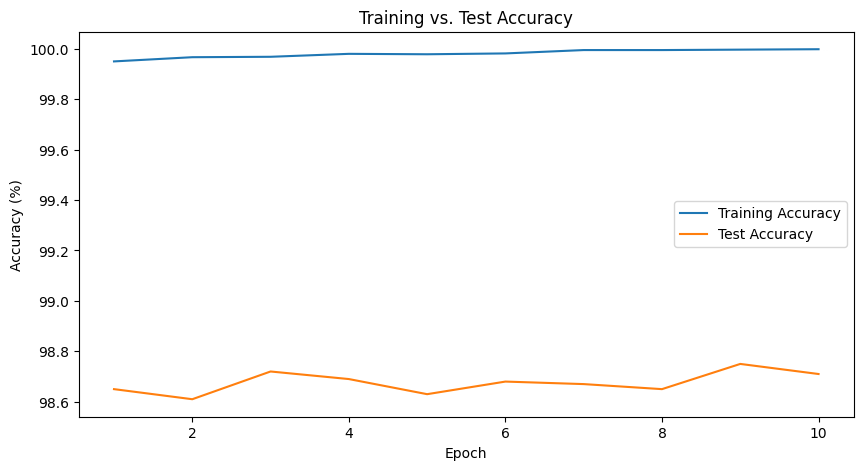

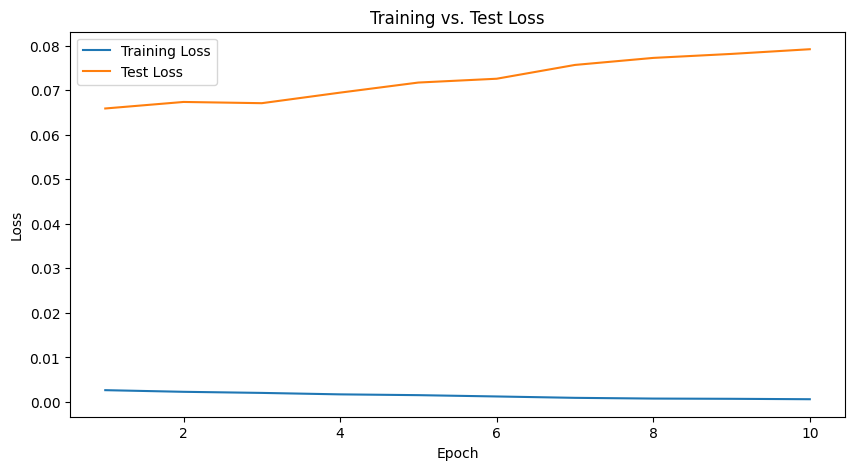

In [ ]:
import torch.nn.functional as F

num_epochs = 10

def train_and_evaluate(num_epochs, cnn, loaders):
    # Lists to store loss and accuracy for each epoch
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        cnn.train()  # Set model to training mode
        
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in loaders['train']:            
            # Forward pass
            output = cnn(images)[0]

            # Apply softmax to get probabilities
            probabilities = F.softmax(output, dim=1)

            loss = loss_func(output, labels)
            total_train_loss += loss.item()
            
            # Predictions for training accuracy
            _, predicted = torch.max(probabilities, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Calculate training metrics
        avg_train_loss = total_train_loss / len(loaders['train'])
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test data
        test_loss, test_accuracy = evaluate(cnn, loaders['test'])
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    # Plot training and test accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs. Test Accuracy')
    plt.legend()
    plt.show()
    
    # Plot training and test loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Test Loss')
    plt.legend()
    plt.show()

# Call the function
train_and_evaluate(num_epochs, cnn, loaders)


# NOTE: If loss is bouncing around a lot, that means the lr is too high
# NOTE: train doesnt always show improvements that test does. Hence running a test every epoch and comparing the 

# Overfitting: What it looks like
# train accuracy will increase, but test accuracy decreases

# Underfitting: What it looks like
# both train and test accuracy plateau early

### Evaluate the model on test data
We must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference.

model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.

You can call either model.eval() or model.train(mode=False) to tell that you are testing the model.

In [16]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
test()

# visualize testing loss over time

Test Accuracy of the model on the 10000 test images: 0.96


Prediction number: [5 0 0 3 8 3 8 8 7 4]
Actual number    : [5 0 0 3 8 3 8 8 7 4]


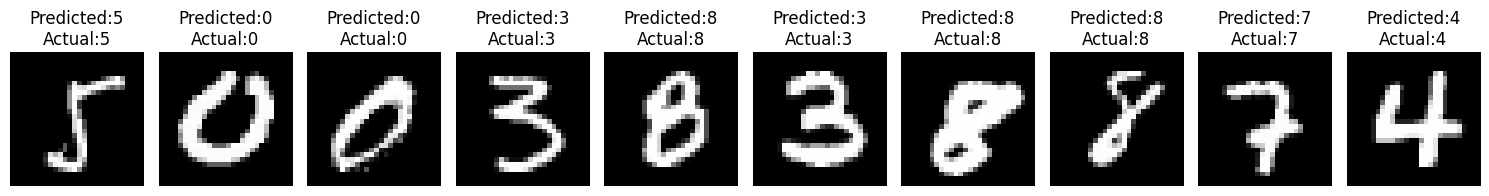

In [24]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number    : {actual_number}')

# Display the images with predicted and actual labels
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    ax = axes[i]
    ax.imshow(imgs[i].squeeze(), cmap='gray')
    ax.set_title(f'Predicted:{pred_y[i]}\nActual:{actual_number[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()



### For my project

Include orientation in the output of the detection. If possible add velocity (motion blur). The detection will give me a center point then i get the length in each dimension (x and y)

- Steerable CNNs are more computationally efficient than group equivariance bc you come up with a basis for the group that represents the groups equivariance
- First, you come up with the matrix representation for a group (ex. SO2 is like 2 by 2 matrix cos and sin). Then you create x amount of filter kernels of that matrix. 
- Your parameter is theta in this case and then you learn the different thetas that will inheritently be equivariant to the entire group.
- IMPORTANT PART: Theta in this case is just so you have a degree of freedom because your model needs to learn something
- You choose that parameter such that its a representation of the group and inherently equivariant to it NO MATTER what value is takes

![SO2 Image](so2.png)